In [2]:
import matplotlib.pyplot as plt
import numpy as np
from rasterio import plot
import pandas as pd
import sys
import os
import gdal
import shapefile
import csv
import time

from math import sqrt

import rasterstats as rs

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import geopandas as gpd
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
def array_to_raster(array, old_raster_used_for_projection, save_path):

    width = old_raster_used_for_projection.RasterYSize
    height = old_raster_used_for_projection.RasterXSize
    gt = old_raster_used_for_projection.GetGeoTransform()
    wkt_projection = old_raster_used_for_projection.GetProjectionRef()

    
    if len(array.shape):
        array = np.expand_dims(array, axis=0)

    no_bands =  array.shape[0]

    
    driver = gdal.GetDriverByName('GTiff')
    DataSet = driver.Create(save_path, height, width, no_bands, gdal.GDT_Float64)
    DataSet.SetGeoTransform(gt)
    DataSet.SetProjection(wkt_projection)
    
    
    for i, image in enumerate(array, 1):
        DataSet.GetRasterBand(i).WriteArray(image)
    DataSet = None
    
    return save_path

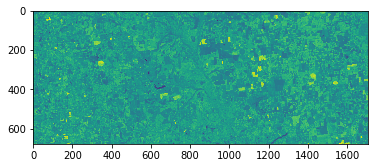

[-0.21042635 -0.20319676 -0.20148262 ...  0.53823687  0.53919694
  0.53970803]


In [4]:
data_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Data/'
labels_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Ground_Truth_Data/'
shapefiles_folder_path = data_folder_path + 'Shapefiles/'

indeces = ['ndvi']#,'evi']


if 'ndvi' in indeces:
    ndvi_data_tif_path = data_folder_path + 'NDVI_raster.tif'
    ndvi_data_tif = gdal.Open(ndvi_data_tif_path)
    ndvi_data = np.array(ndvi_data_tif.GetRasterBand(1).ReadAsArray())
    plot.show(ndvi_data)
    print(np.unique(ndvi_data))
    
if 'evi' in indeces:
    evi_data_tif_path = data_folder_path + 'EVI_raster.tif'
    evi_data_tif = gdal.Open(evi_data_tif_path)
    evi_data = np.array(evi_data_tif.GetRasterBand(1).ReadAsArray())
    plot.show(evi_data)
    print(np.unique(evi_data))



In [5]:
shapefiles_name_list = os.listdir(data_folder_path + 'Shapefiles/')
shapefiles_name_list = sorted([file for file in shapefiles_name_list if file.endswith('shp')])
labels_nums = list(range(len(shapefiles_name_list)))
crop_names_list = [x.split('_')[0] for x in shapefiles_name_list]

print(shapefiles_name_list)
print(labels_nums)
print(crop_names_list)

['Corn_shapefile_64.shp', 'Cotton_shapefile_64.shp', 'Peanuts_shapefile_64.shp']
[0, 1, 2]
['Corn', 'Cotton', 'Peanuts']


In [6]:
#OPEN MULTIBAND DATA TIF AND SAVE THEM AS SEPERATE BAND TIF
if 'ndvi' in indeces:
    ndvi_data = gdal.Open(ndvi_data_tif_path)
    no_bands = ndvi_data.RasterCount
    ndvi_data_array = []
    ndvi_data_tif = []
    for i in range(no_bands):
        ndvi_data_tif.append(ndvi_data.GetRasterBand(i+1))
        ndvi_data_array.append(ndvi_data.GetRasterBand(i+1).ReadAsArray())
    #     print(ndvi_data_array[i].shape)
    #     plot.show(ndvi_data_array[i])

        array_to_raster(ndvi_data_array[i],ndvi_data,data_folder_path + 'ndvi_date_' + str(i+1))
    
if 'evi' in indeces:
    evi_data = gdal.Open(evi_data_tif_path)
    no_bands = evi_data.RasterCount
    evi_data_array = []
    evi_data_tif = []
    for i in range(no_bands):
        evi_data_tif.append(evi_data.GetRasterBand(i+1))
        evi_data_array.append(evi_data.GetRasterBand(i+1).ReadAsArray())
    #     print(ndvi_data_array[i].shape)
    #     plot.show(ndvi_data_array[i])

        array_to_raster(evi_data_array[i],evi_data,data_folder_path + 'evi_date_' + str(i+1))
    
    

In [25]:
#OPEN SEPERATE BAND TIFS AND CALCULATE STATISTICS USING SHAPEFILES
if 'ndvi' in indeces:
    ndvi_stats_dicts_for_each_crop_and_date = []
    for shape in shapefiles_name_list:
#         print(shape)
        summed_file_path = shapefiles_folder_path + shape
#         print(summed_file_path)
        ndvi_stats_of_each_date = []
        for i in range(len(ndvi_data_tif)):
#             print(i)
            ndvi_stats_of_each_date.append(rs.zonal_stats(summed_file_path, data_folder_path + 'ndvi_date_' + str(i+1), stats="count min mean max", nodata=-9999))
        ndvi_stats_dicts_for_each_crop_and_date.append(ndvi_stats_of_each_date)

        
if 'evi' in indeces:
    evi_stats_dicts_for_each_crop_and_date = []
    for shape in shapefiles_name_list:
#         print(shape)
        summed_file_path = shapefiles_folder_path + shape
#         print(summed_file_path)
        evi_stats_of_each_date = []
        for i in range(len(evi_data_tif)):
#             print(i)
            evi_stats_of_each_date.append(rs.zonal_stats(summed_file_path, data_folder_path + 'evi_date_' + str(i+1), stats="count min mean max", nodata=-9999))
        evi_stats_dicts_for_each_crop_and_date.append(evi_stats_of_each_date)   

In [8]:
#SAVE THE STATISTICS AS CSVs
csv_path = data_folder_path + 'CSVs/'
for idx,crop in enumerate(crop_names_list):
    if 'ndvi' in indeces:    
        for i in range(len(ndvi_stats_dicts_for_each_crop_and_date[idx])):
            toCSV = ndvi_stats_dicts_for_each_crop_and_date[idx][i]
            keys = toCSV[0].keys()
            with open(csv_path + crop_names_list[idx] + '_date_' + str(i+1) + '_ndvi_stats.csv', 'w') as output_file:
                dict_writer = csv.DictWriter(output_file, keys)
                dict_writer.writeheader()
                dict_writer.writerows(toCSV)

    if 'evi' in indeces:
        for i in range(len(evi_stats_dicts_for_each_crop_and_date[idx])):
            toCSV = evi_stats_dicts_for_each_crop_and_date[idx][i]
            keys = toCSV[0].keys()
            with open(csv_path + crop_names_list[idx] + '_date_' + str(i+1) + '_evi_stats.csv', 'w') as output_file:
                dict_writer = csv.DictWriter(output_file, keys)
                dict_writer.writeheader()
                dict_writer.writerows(toCSV)


In [26]:
#READ CSVs WITH STATISTICS, TAKE THE METRIC TO UTILIZE, CREATE DATA AND LABELS ARRAYS PER CROP
#crop_arrays = []
if 'ndvi' in indeces:
    ndvi_means = []
    ndvi_labels = []
    for j,crop in enumerate(crop_names_list):
        date_array = []
        for i in range(no_bands):
            stats = pd.read_csv(data_folder_path + 'CSVs/'+ crop + '_date_' + str(i+1) +'_ndvi_stats.csv')
            date_array.append(stats.values)
    #    crop_arrays.append(np.asarray(date_array))
        temp = np.asarray(date_array)[:,:,2] #mean
        print(temp.shape)
        ndvi_labels.append(np.ones(temp.shape[1])*labels_nums[j])
        ndvi_means.append(np.transpose(temp))
        print(ndvi_means[j].shape)


if 'evi' in indeces:
    evi_means = []
    evi_labels = []
    for j,crop in enumerate(crop_names_list):
        date_array = []
        for i in range(no_bands):
            stats = pd.read_csv(data_folder_path + 'CSVs/'+ crop + '_date_' + str(i+1) +'_evi_stats.csv')
            date_array.append(stats.values)
    #    crop_arrays.append(np.asarray(date_array))
        temp = np.asarray(date_array)[:,:,2] #mean
        print(temp.shape)
        evi_labels.append(np.ones(temp.shape[1])*labels_nums[j])
        evi_means.append(np.transpose(temp))
        print(evi_means[j].shape)


(14, 49)
(49, 14)
(14, 359)
(359, 14)
(14, 248)
(248, 14)


In [14]:
print(('evi' or 'ndvi') in indeces)
if ('evi' or 'ndvi') in indeces:
    for i in range(len(ndvi_means)):
        print(ndvi_means[i].shape)
        print(evi_means[i].shape)
        ndvi_means[i] = np.concatenate([ndvi_means[i],evi_means[i]],axis=1)


False


In [19]:
#CREATE TRAIN TEST DATASETS FOR ML CLASSIFIERS
#apply the ratio on each crop independently and not on all of them after they are concatenated, so
#as to train effectively for each class
train_x = []
test_x = []
train_y = []
test_y = []

train_test_ratio = 0.2

train_x, test_x, train_y, test_y = train_test_split(ndvi_means[0], ndvi_labels[0], test_size=train_test_ratio, random_state=42)

X_train = train_x
X_test = test_x
y_train = train_y
y_test = test_y


for i in range(1, len(ndvi_means)):

    train_x, test_x, train_y, test_y = train_test_split(ndvi_means[i], ndvi_labels[i], test_size=train_test_ratio, random_state=42)
    X_train = np.concatenate([X_train,train_x])
    X_test = np.concatenate([X_test,test_x])
    y_train = np.concatenate([y_train,train_y])
    y_test = np.concatenate([y_test,test_y])
    
    
    
    



# for i in range(len(train_x)):

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(524, 14)
(132, 14)
(524,)
(132,)


In [20]:
clf = RandomForestClassifier(random_state=0)
start_train = time.time()
clf.fit(X_train, y_train)
end_train = time.time()
print(end_train - start_train)

start_test = time.time()
result = clf.score(X_test,y_test)
end_test = time.time()
print(end_test - start_test)

print(result)

0.01398921012878418
0.0014276504516601562
0.9318181818181818


/home/chris/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
clf = SVC(gamma='auto')
start_train = time.time()
clf.fit(X_train, y_train)
end_train = time.time()
print(end_train - start_train)

start_test = time.time()
result = clf.score(X_test,y_test)
end_test = time.time()
print(end_test - start_test)

print(result)

0.013117790222167969
0.003091573715209961
0.8787878787878788


In [22]:
neigh_num = 30
neigh = KNeighborsClassifier(n_neighbors=neigh_num)

start_train = time.time()
neigh.fit(X_train, y_train)
end_train = time.time()

print(end_train - start_train)

start_test = time.time()
result = neigh.score(X_test,y_test)
end_test = time.time()

print(end_test - start_test)

print(result)


0.0012664794921875
0.010154008865356445
0.9015151515151515


In [17]:
#TRAIN-TEST DATASETS FOR RMSE METHOD
#GETTING THE MEANS OF EACH CLASS AND USING RMSE WE CLASSIFY THE TEST DATA TO THE MINIMUM ERROR CLASS
X_test = []
y_test = []

train_test_ratio = 0.2


means = []
for i in range(len(ndvi_means)): 
    train_x, test_x, train_y, test_y = train_test_split(ndvi_means[i], ndvi_labels[i], test_size=train_test_ratio, random_state=42)
    
    means.append(np.mean(train_x, axis=0))
    
    X_test.append(test_x)
    y_test.append(test_y)

print(means[0].shape)
print(X_test[0].shape)
print(means[0].shape)
print(y_test[0].shape)

(14,)
(10, 14)
(14,)
(10,)


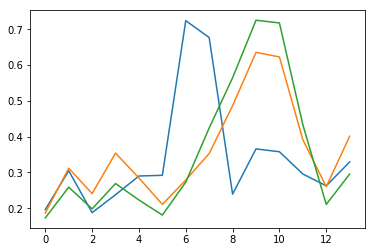

In [28]:
plt.plot(means[0])
plt.plot(means[1])
plt.plot(means[2])

In [30]:
print(means[2].shape)
print(X_test[2].shape)
print(means[2].shape)
print(y_test[2].shape)

test_data = np.concatenate([X_test[0],X_test[1],X_test[2]])
test_labels = np.concatenate([y_test[0],y_test[1],y_test[2]])

print(test_data.shape)
print(test_labels.shape)

results = []
for vec in test_data:
    rmse = []
    for crop_graph in means:
        
        rmse.append(sqrt(mean_squared_error(crop_graph, vec)))
    results.append(rmse.index(min(rmse)))
    
    
       
diff = results - test_labels
accuracy = len(diff[diff==0])/len(diff)
print(accuracy)    

(14,)
(50, 14)
(14,)
(50,)
(132, 14)
(132,)
0.8409090909090909


In [22]:
conf = confusion_matrix(test_labels, results)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

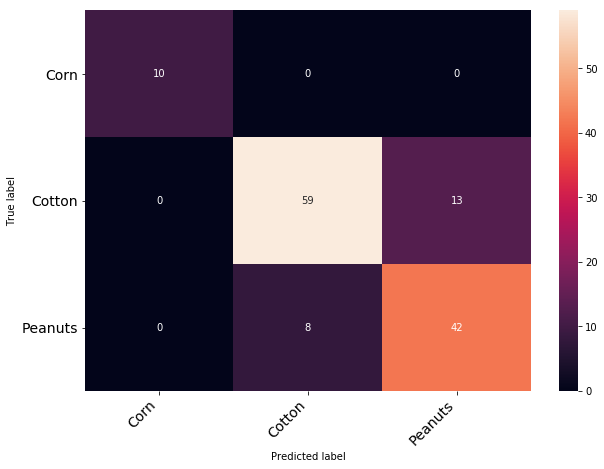

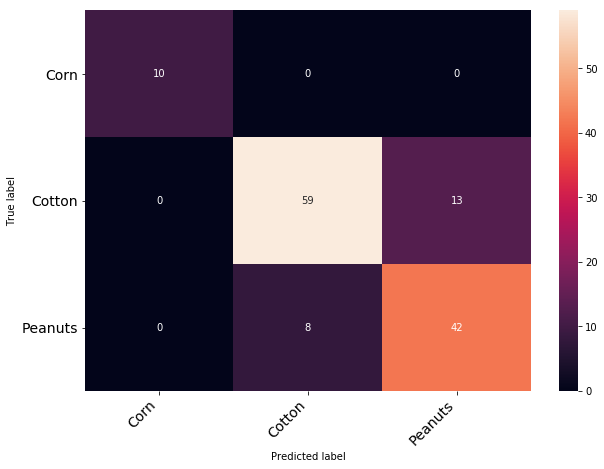

In [24]:
print_confusion_matrix(conf,crop_names_list)

In [12]:
means = []
for crop in ndvi_means:
    means.append(np.mean(crop, axis=0))

#rmse = sqrt(mean_squared_error(y_actual, y_predicted))